<a href="https://colab.research.google.com/github/osbornep8/NMA_2023/blob/main/Model%20Fitting/Multiple%20linear%20regression%20and%20polynomial%20regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 4: Multiple linear regression and polynomial regression

**Week 1, Day 2: Model Fitting**

**By Neuromatch Academy**

**Content creators**: Pierre-Étienne Fiquet, Anqi Wu, Alex Hyafil with help from Byron Galbraith, Ella Batty

**Content reviewers**: Lina Teichmann, Saeed Salehi, Patrick Mineault, Michael Waskom

**Production editors:** Spiros Chavlis

---
# Setup

In [ ]:
# @title Install and import feedback gadget

!pip3 install vibecheck datatops --quiet

from vibecheck import DatatopsContentReviewContainer
def content_review(notebook_section: str):
    return DatatopsContentReviewContainer(
        "",  # No text prompt
        notebook_section,
        {
            "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
            "name": "neuromatch_cn",
            "user_key": "y1x3mpx5",
        },
    ).render()


feedback_prefix = "W1D2_T4"

In [ ]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# @title Figure Settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [ ]:
# @title Plotting Functions

def evaluate_fits(order_list, mse_list):
  """ Compare the quality of multiple polynomial fits
  by plotting their MSE values.

  Args:
    order_list (list): list of the order of polynomials to be compared
    mse_list (list): list of the MSE values for the corresponding polynomial fit
  """
  fig, ax = plt.subplots()
  ax.bar(order_list, mse_list)
  ax.set(title='Comparing Polynomial Fits', xlabel='Polynomial order', ylabel='MSE')
  plt.show()


def plot_fitted_polynomials(x, y, theta_hat):
  """ Plot polynomials of different orders

  Args:
    x (ndarray): input vector of shape (n_samples)
    y (ndarray): vector of measurements of shape (n_samples)
    theta_hat (dict): polynomial regression weights for different orders
  """

  x_grid = np.linspace(x.min() - .5, x.max() + .5)

  plt.figure()

  for order in range(0, max_order + 1):
    X_design = make_design_matrix(x_grid, order)
    plt.plot(x_grid, X_design @ theta_hat[order]);

  plt.ylabel('y')
  plt.xlabel('x')
  plt.plot(x, y, 'C0.');
  plt.legend([f'order {o}' for o in range(max_order + 1)], loc=1)
  plt.title('polynomial fits')
  plt.show()

---
# Section 1: Multiple Linear Regression

*Estimated timing to here from start of tutorial: 8 min*

This video covers linear regression with multiple inputs (more than 1D) and polynomial regression.

<details>
<summary> <font color='blue'>Click here for text recap of video </font></summary>

Now that we have considered the univariate case and how to produce confidence intervals for our estimator, we turn to the general linear regression case, where we can have more than one regressor, or feature, in our input.

Recall that our original univariate linear model was given as

\begin{equation}
y = \theta x + \epsilon
\end{equation}

where $\theta$ is the slope and $\epsilon$ some noise. We can easily extend this to the multivariate scenario by adding another parameter for each additional feature

\begin{equation}
y = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + ... +\theta_d x_d + \epsilon
\end{equation}

where $\theta_0$ is the intercept and $d$ is the number of features (it is also the dimensionality of our input).

We can condense this succinctly using vector notation for a single data point

\begin{equation}
y_i = \boldsymbol{\theta}^{\top}\mathbf{x}_i + \epsilon
\end{equation}

and fully in matrix form

\begin{equation}
\mathbf{y} = \mathbf{X}\boldsymbol{\theta} + \mathbf{\epsilon}
\end{equation}

where $\mathbf{y}$ is a vector of measurements, $\mathbf{X}$ is a matrix containing the feature values (columns) for each input sample (rows), and $\boldsymbol{\theta}$ is our parameter vector.

This matrix $\mathbf{X}$ is often referred to as the "[design matrix](https://en.wikipedia.org/wiki/Design_matrix)".

We want to find an optimal vector of paramters $\boldsymbol{\hat\theta}$. Recall our analytic solution to minimizing MSE for a single regressor:

\begin{equation}
\hat\theta = \frac{\sum_{i=1}^N x_i y_i}{\sum_{i=1}^N x_i^2}.
\end{equation}

The same holds true for the multiple regressor case, only now expressed in matrix form

\begin{equation}
\boldsymbol{\hat\theta} = (\mathbf{X}^\top\mathbf{X})^{-1}\mathbf{X}^\top\mathbf{y}.
\end{equation}

This is called the [ordinary least squares](https://en.wikipedia.org/wiki/Ordinary_least_squares) (OLS) estimator.
</details>

For this tutorial we will focus on the two-dimensional case ($d=2$), which allows us to easily visualize our results. As an example, think of a situation where a scientist records the spiking response of a retinal ganglion cell to patterns of light signals that vary in contrast and in orientation. Then contrast and orientation values can be used as features / regressors to predict the cells response.

In this case our model can be written for a single data point as:

\begin{equation}
y = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \epsilon
\end{equation}

or for multiple data points in matrix form where

\begin{equation}
\mathbf{X} =
\begin{bmatrix}
1 & x_{1,1} & x_{1,2} \\
1 & x_{2,1} & x_{2,2} \\
\vdots & \vdots & \vdots \\
1 & x_{n,1} & x_{n,2}
\end{bmatrix},
\boldsymbol{\theta} =
\begin{bmatrix}
\theta_0 \\
\theta_1 \\
\theta_2 \\
\end{bmatrix}
\end{equation}

When we refer to $x_{i, j}$, we mean that it is the i-th data point and the j-th feature of that data point.

For our actual exploration dataset we shall set $\boldsymbol{\theta}=[0, -2, -3]$ and draw $N=40$ noisy samples from $x \in [-2,2)$. Note that setting the value of $\theta_0 = 0$ effectively ignores the offset term.

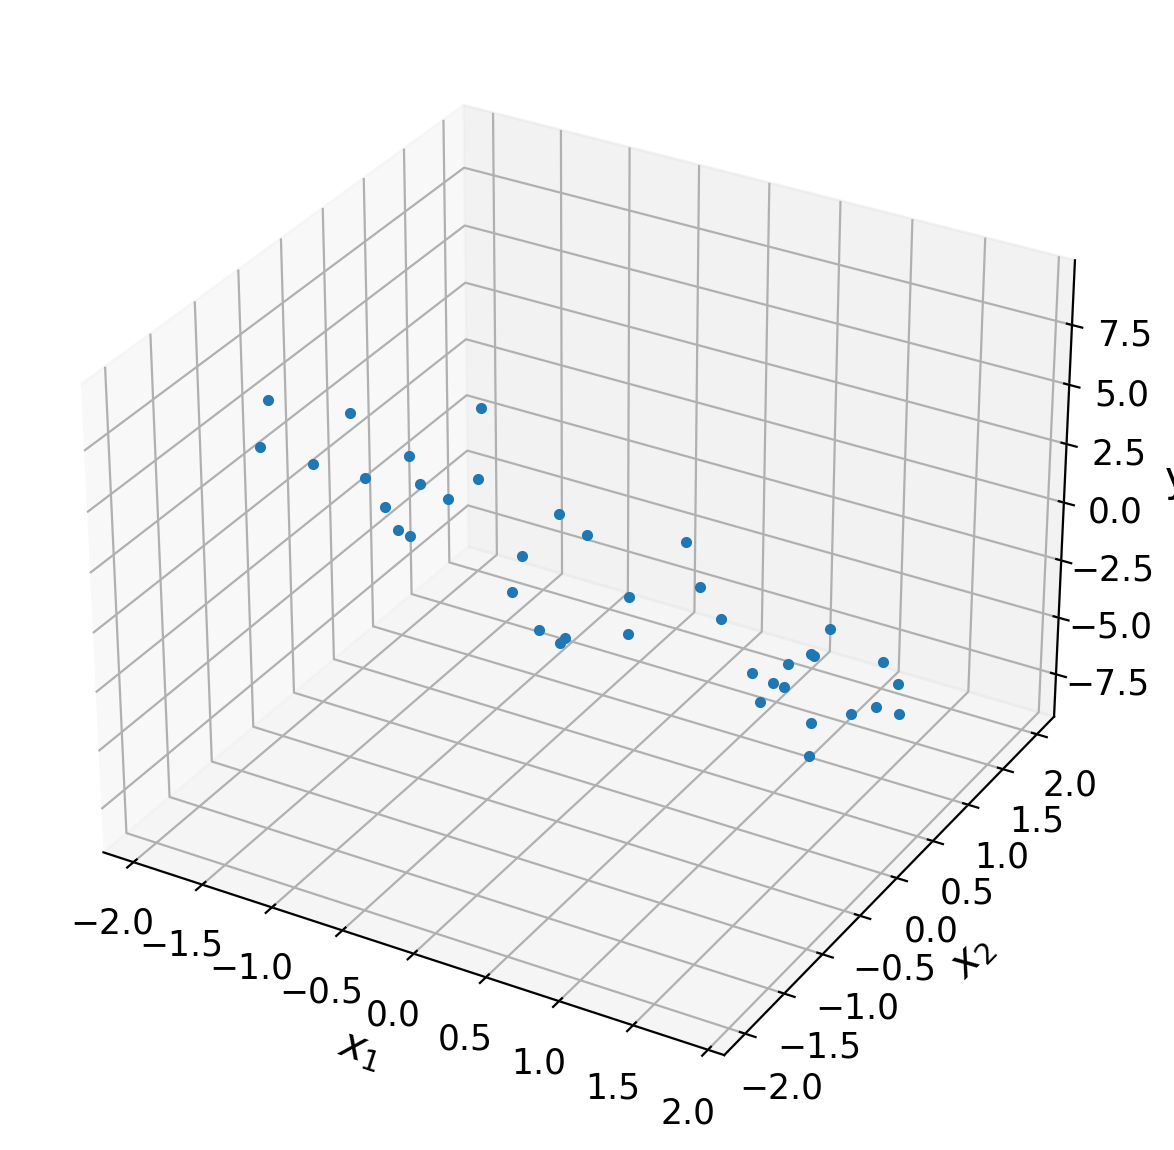

In [ ]:
# @markdown Execute this cell to simulate some data

# Set random seed for reproducibility
np.random.seed(1234)

# Set parameters
theta = [0, -2, -3]
n_samples = 40

# Draw x and calculate y
n_regressors = len(theta)
x0 = np.ones((n_samples, 1))
x1 = np.random.uniform(-2, 2, (n_samples, 1))
x2 = np.random.uniform(-2, 2, (n_samples, 1))
X = np.hstack((x0, x1, x2))
noise = np.random.randn(n_samples)
y = X @ theta + noise


ax = plt.subplot(projection='3d')
ax.plot(X[:,1], X[:,2], y, '.')

ax.set(
    xlabel='$x_1$',
    ylabel='$x_2$',
    zlabel='y'
)
plt.tight_layout()

## Coding Exercise 1: Ordinary Least Squares Estimator

In this exercise you will implement the OLS approach to estimating $\boldsymbol{\hat\theta}$ from the design matrix $\mathbf{X}$ and measurement vector $\mathbf{y}$. You can use the `@` symbol for matrix multiplication, `.T` for transpose, and `np.linalg.inv` for matrix inversion.


In [ ]:
def ordinary_least_squares(X, y):
  """Ordinary least squares estimator for linear regression.

  Args:
    x (ndarray): design matrix of shape (n_samples, n_regressors)
    y (ndarray): vector of measurements of shape (n_samples)

  Returns:
    ndarray: estimated parameter values of shape (n_regressors)
  """
  ######################################################################
  ## TODO for students: solve for the optimal parameter vector using OLS
  # Fill out function and remove
  #raise NotImplementedError("Student exercise: solve for theta_hat vector using OLS")
  ######################################################################

  # Compute theta_hat using OLS
  theta_hat = np.linalg.inv(X.T@X)@((X.T)@y)

  return theta_hat


theta_hat = ordinary_least_squares(X, y)
print(theta_hat)

[ 0.13861386 -2.09395731 -3.16370742]


Now that we have our $\boldsymbol{\hat\theta}$, we can obtain $\hat{\mathbf{y}}$ and thus our mean squared error.

In [ ]:
# Compute predicted data
theta_hat = ordinary_least_squares(X, y)
y_hat = X @ theta_hat

# Compute MSE
print(f"MSE = {np.mean((y - y_hat)**2):.2f}")

MSE = 0.91


Finally, the following code will plot a geometric visualization of the data points (blue) and fitted plane.

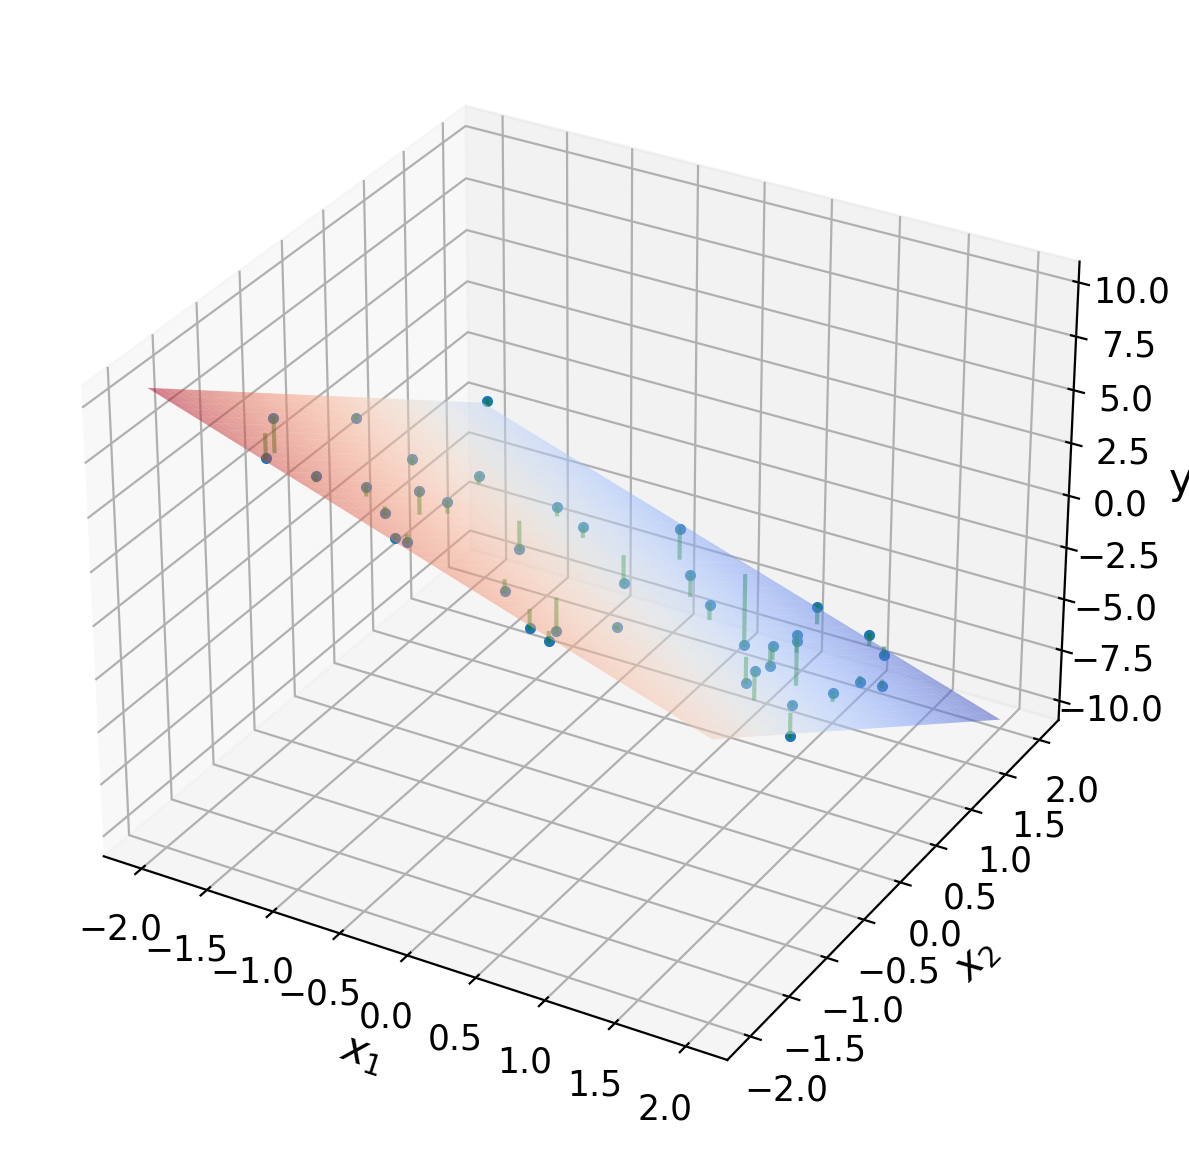

In [ ]:
# @markdown Execute this cell to visualize data and predicted plane

theta_hat = ordinary_least_squares(X, y)
xx, yy = np.mgrid[-2:2:50j, -2:2:50j]
y_hat_grid = np.array([xx.flatten(), yy.flatten()]).T @ theta_hat[1:]
y_hat_grid = y_hat_grid.reshape((50, 50))

ax = plt.subplot(projection='3d')
ax.plot(X[:, 1], X[:, 2], y, '.')
ax.plot_surface(xx, yy, y_hat_grid, linewidth=0, alpha=0.5, color='C1',
                cmap=plt.get_cmap('coolwarm'))

for i in range(len(X)):
  ax.plot((X[i, 1], X[i, 1]),
          (X[i, 2], X[i, 2]),
          (y[i], y_hat[i]),
          'g-', alpha=.5)

ax.set(
    xlabel='$x_1$',
    ylabel='$x_2$',
    zlabel='y'
)
plt.tight_layout()
plt.show()

---
# Section 2:  Polynomial Regression


So far today, you learned how to predict outputs from inputs by fitting a linear regression model. We can now model all sorts of relationships, including in neuroscience!

One potential problem with this approach is the simplicity of the model. Linear regression, as the name implies, can only capture a linear relationship between the inputs and outputs. Put another way, the predicted outputs are only a weighted sum of the inputs. What if there are more complicated computations happening? Luckily, many more complex models exist (and you will encounter many more over the next 3 weeks). One model that is still very simple to fit and understand, but captures more complex relationships, is **polynomial regression**, an extension of linear regression.


Since polynomial regression is an extension of linear regression, everything you learned so far will come in handy now! The goal is the same: we want to predict the dependent variable $y$ given the input values $x$. The key change is the type of relationship between inputs and outputs that the model can capture.

Linear regression models predict the outputs as a weighted sum of the inputs:

\begin{equation}
y = \theta_0 + \theta x + \epsilon
\end{equation}

With polynomial regression, we model the outputs as a polynomial equation based on the inputs. For example, we can model the outputs as:

\begin{equation}
y = \theta_0 + \theta_1 x + \theta_2 x^2 + \theta_3 x^3 + \epsilon
\end{equation}

We can change how complex a polynomial is fit by changing the order of the polynomial. The order of a polynomial refers to the highest power in the polynomial. The equation above is a third order polynomial because the highest value x is raised to is 3. We could add another term ($+ \theta_4 x^4$) to model an order 4 polynomial and so on.
</details>


First, we will simulate some data to practice fitting polynomial regression models. We will generate random inputs $x$ and then compute y according to $y = x^2 - x - 2 $, with some extra noise both in the input and the output to make the model fitting exercise closer to a real life situation.

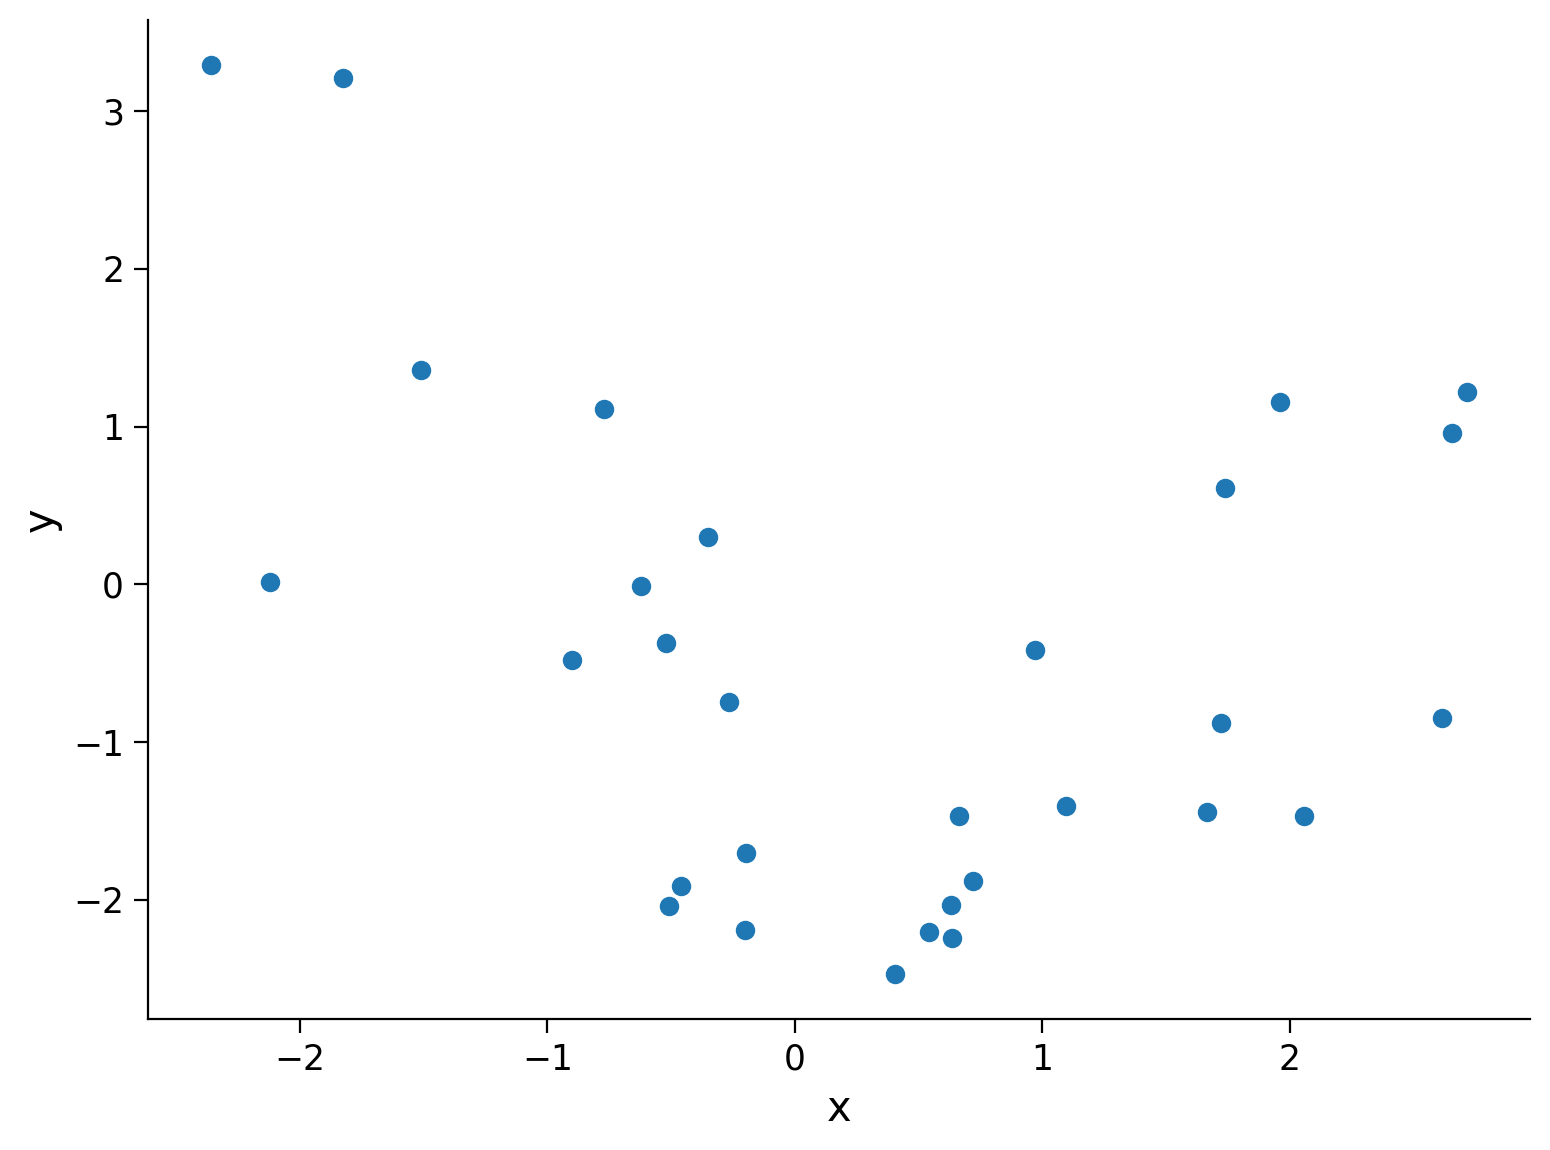

In [ ]:
# @markdown Execute this cell to simulate some data

# setting a fixed seed to our random number generator ensures we will always
# get the same psuedorandom number sequence
np.random.seed(121)
n_samples = 30
x = np.random.uniform(-2, 2.5, n_samples)  # inputs uniformly sampled from [-2, 2.5)
y =  x**2 - x - 2   # computing the outputs

output_noise = 1/8 * np.random.randn(n_samples)
y += output_noise  # adding some output noise

input_noise = 1/2 * np.random.randn(n_samples)
x += input_noise  # adding some input noise

fig, ax = plt.subplots()
ax.scatter(x, y)  # produces a scatter plot
ax.set(xlabel='x', ylabel='y');

## Section 2.1: Design matrix for polynomial regression

*Estimated timing to here from start of tutorial: 16 min*

Now we have the basic idea of polynomial regression and some noisy data, let's begin! The key difference between fitting a linear regression model and a polynomial regression model lies in how we structure the input variables.

Let's go back to one feature for each data point. For linear regression, we used $\mathbf{X} = \mathbf{x}$ as the input data, where $\mathbf{x}$ is a vector where each element is the input for a single data point. To add a constant bias (a y-intercept in a 2-D plot), we use $\mathbf{X} = \big[ \boldsymbol 1, \mathbf{x} \big]$, where $\boldsymbol 1$ is a column of ones.  When fitting, we learn a weight for each column of this matrix. So we learn a weight that multiples with column 1 - in this case that column is all ones so we gain the bias parameter ($+ \theta_0$).

This matrix $\mathbf{X}$ that we use for our inputs is known as a **design matrix**. We want to create our design matrix so we learn weights for $\mathbf{x}^2, \mathbf{x}^3,$ etc. Thus, we want to build our design matrix $X$ for polynomial regression of order $k$ as:

\begin{equation}
\mathbf{X} = \big[ \boldsymbol 1 , \mathbf{x}^1, \mathbf{x}^2 , \ldots , \mathbf{x}^k \big],
\end{equation}

where $\boldsymbol{1}$ is the vector the same length as $\mathbf{x}$ consisting of of all ones, and $\mathbf{x}^p$ is the vector $\mathbf{x}$ with all elements raised to the power $p$. Note that $\boldsymbol{1} = \mathbf{x}^0$ and $\mathbf{x}^1 = \mathbf{x}$.

If we have inputs with more than one feature, we can use a similar design matrix but include all features raised to each power. Imagine that we have two features per data point: $\mathbf{x}_m$ is a vector of one feature per data point and  $\mathbf{x}_n$ is another.  Our design matrix for a polynomial regression would be:

\begin{equation}
\mathbf{X} = \big[ \boldsymbol 1 , \mathbf{x}_m^1, \mathbf{x}_n^1, \mathbf{x}_m^2 , \mathbf{x}_n^2\ldots , \mathbf{x}_m^k , \mathbf{x}_n^k \big],
\end{equation}

### Coding Exercise 2.1: Structure design matrix

Create a function (`make_design_matrix`) that structures the design matrix given the input data and the order of the polynomial you wish to fit. We will print part of this design matrix for our data and order 5.

In [ ]:
def make_design_matrix(x, order):
  """Create the design matrix of inputs for use in polynomial regression

  Args:
    x (ndarray): input vector of shape (n_samples)
    order (scalar): polynomial regression order

  Returns:
    ndarray: design matrix for polynomial regression of shape (samples, order+1)
  """
  ########################################################################
  ## TODO for students: create the design matrix ##
  # Fill out function and remove
  #raise NotImplementedError("Student exercise: create the design matrix")
  ########################################################################

  # Broadcast to shape (n x 1) so dimensions work
  if x.ndim == 1:
    x = x[:, None]

  #if x has more than one feature, we don't want multiple columns of ones so we assign
  # x^0 here
  design_matrix = np.ones((x.shape[0], 1))

  # Loop through rest of degrees and stack columns (hint: np.hstack)
  for degree in range(1, order + 1):
      design_matrix = np.hstack((design_matrix, (x**degree)))

  return design_matrix


order = 5
X_design = make_design_matrix(x, order)

print(X_design[0:2, 0:2])

[[ 1.         -1.51194917]
 [ 1.         -0.35259945]]


## Section 2.2: Fitting polynomial regression models

*Estimated timing to here from start of tutorial: 24 min*

Now that we have the inputs structured correctly in our design matrix, fitting a polynomial regression is the same as fitting a linear regression model! All of the polynomial structure we need to learn is contained in how the inputs are structured in the design matrix. We can use the same least squares solution we computed in previous exercises.

### Coding Exercise 2.2: Fitting polynomial regression models with different orders

Here, we will fit polynomial regression models to find the regression coefficients ($\theta_0, \theta_1, \theta_2,$ ...) by solving the least squares problem. Create a function `solve_poly_reg` that loops over different order polynomials (up to `max_order`), fits that model, and saves out the weights for each. You may invoke the `ordinary_least_squares` function.

We will then qualitatively inspect the quality of our fits for each order by plotting the fitted polynomials on top of the data. In order to see smooth curves, we evaluate the fitted polynomials on a grid of $x$ values (ranging between the largest and smallest of the inputs present in the dataset).

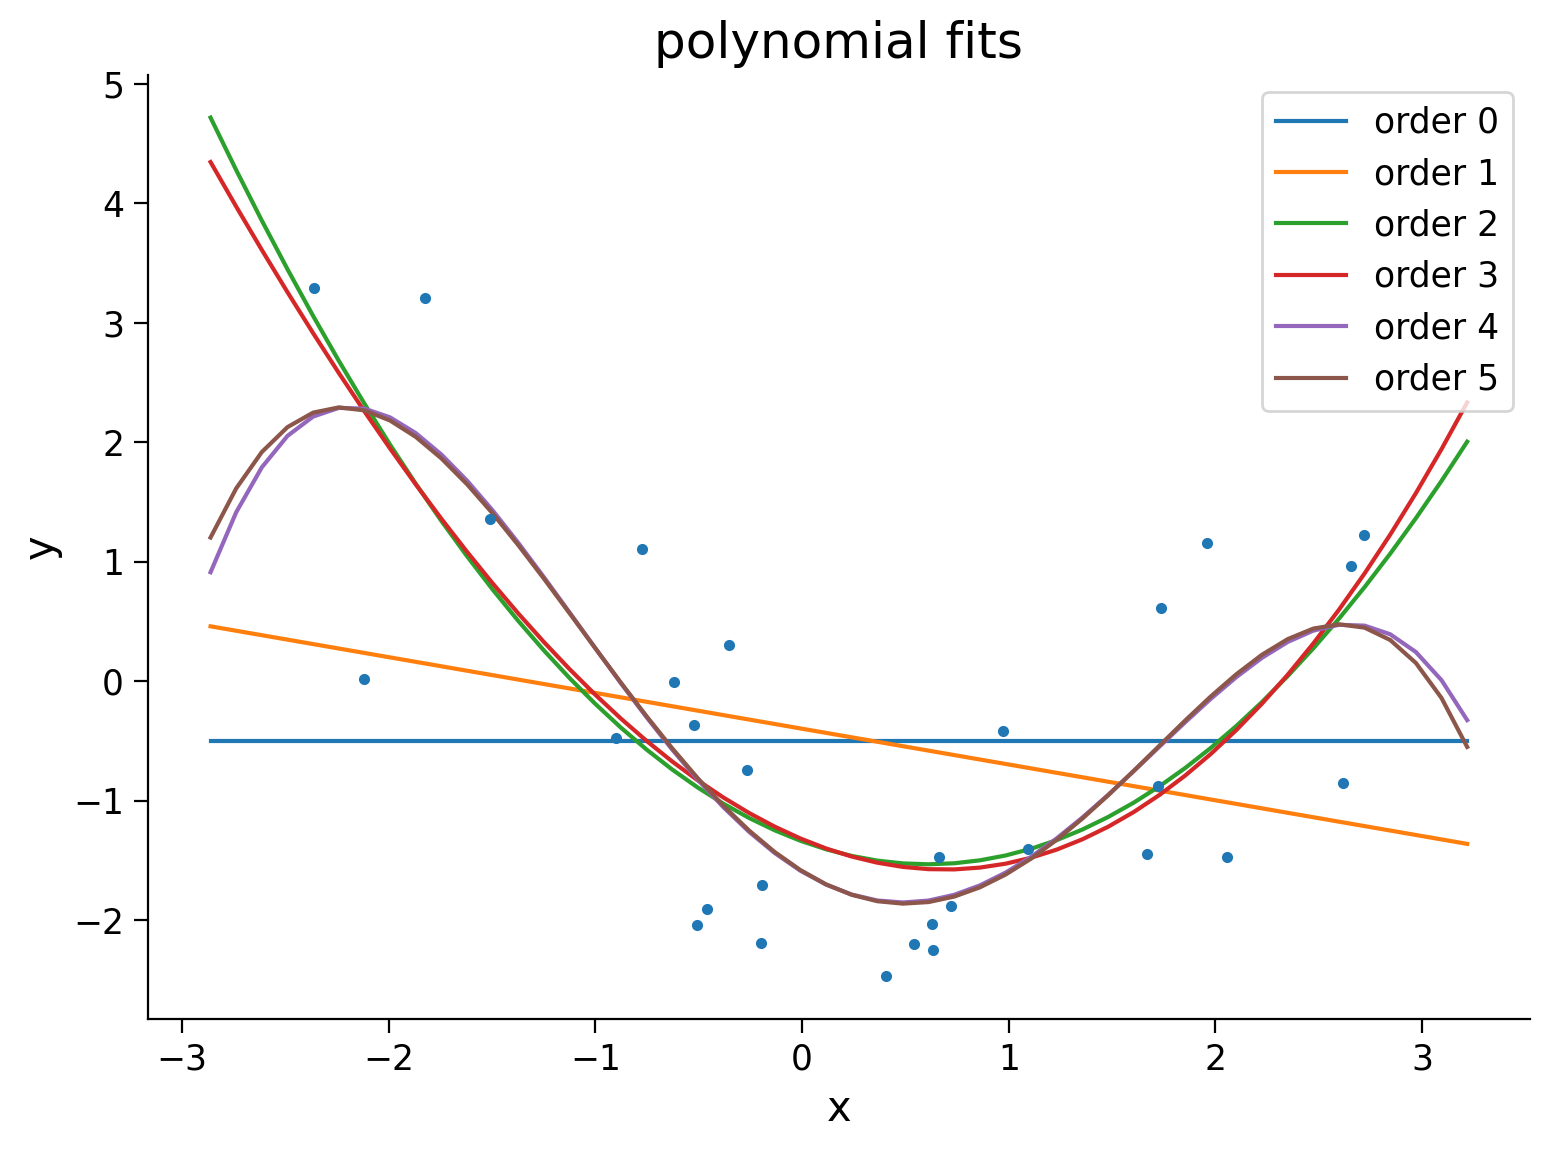

In [ ]:
def solve_poly_reg(x, y, max_order):
  """Fit a polynomial regression model for each order 0 through max_order.

  Args:
    x (ndarray): input vector of shape (n_samples)
    y (ndarray): vector of measurements of shape (n_samples)
    max_order (scalar): max order for polynomial fits

  Returns:
    dict: fitted weights for each polynomial model (dict key is order)
  """

  # Create a dictionary with polynomial order as keys,
  # and np array of theta_hat (weights) as the values
  theta_hats = {}

  # Loop over polynomial orders from 0 through max_order
  for order in range(max_order + 1):

    ##################################################################################
    ## TODO for students: Create design matrix and fit polynomial model for this order
    # Fill out function and remove
    #raise NotImplementedError("Student exercise: fit a polynomial model")
    ##################################################################################

    # Create design matrix
    X_design = make_design_matrix(x, order)

    # Fit polynomial model
    this_theta = ordinary_least_squares(X_design, y)

    theta_hats[order] = this_theta

  return theta_hats


max_order = 5
theta_hats = solve_poly_reg(x, y, max_order)

# Visualize
plot_fitted_polynomials(x, y, theta_hats)

## Section 2.3: Evaluating fit quality

*Estimated timing to here from start of tutorial: 29 min*

As with linear regression, we can compute mean squared error (MSE) to get a sense of how well the model fits the data.

We compute MSE as:

\begin{equation}
\mathrm{MSE} = \frac 1 N ||\mathbf{y} - \hat{\mathbf{y}}||^2 = \frac 1 N \sum_{i=1}^N (y_i - \hat y_i)^2
\end{equation}

where the predicted values for each model are given by $ \hat{\mathbf{y}} = \mathbf{X}\boldsymbol{\hat\theta}$.

*Which model (i.e. which polynomial order) do you think will have the best MSE?*

### Coding Exercise 2.3: Compute MSE and compare models

We will compare the MSE for different polynomial orders with a bar plot.

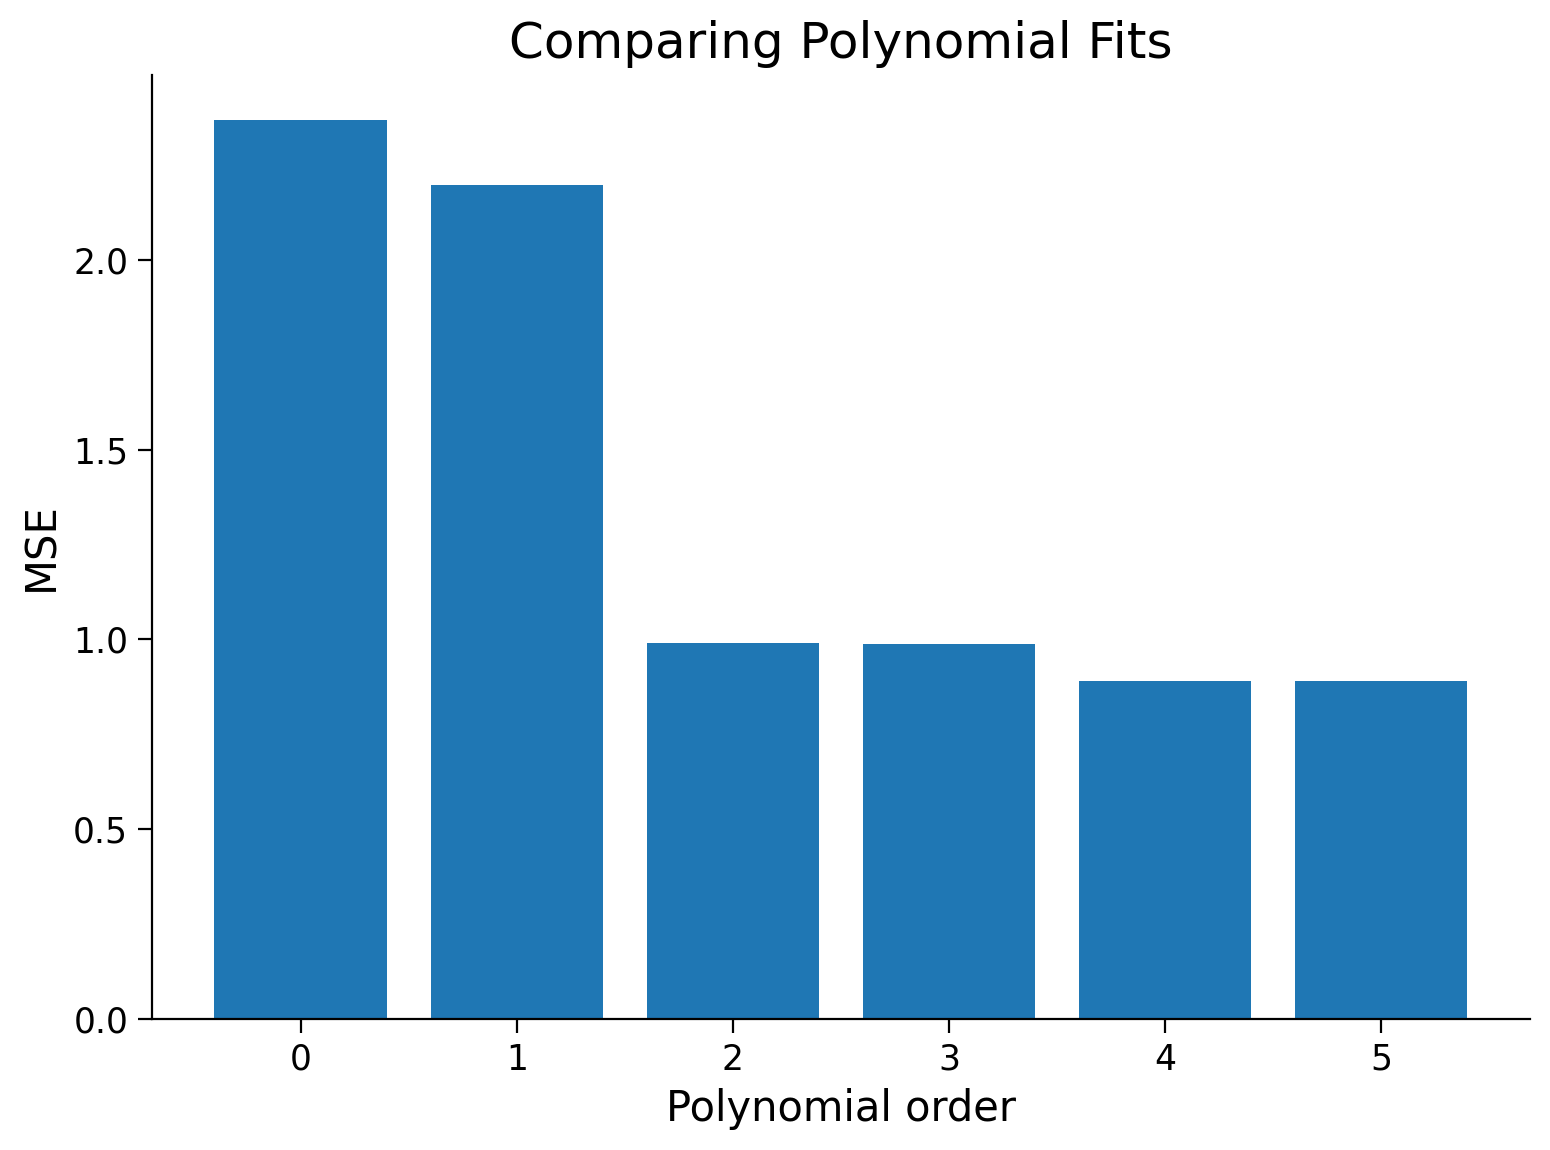

In [ ]:
mse_list = []
order_list = list(range(max_order + 1))

for order in order_list:

  X_design = make_design_matrix(x, order)

  ########################################################################
  ## TODO for students
  # Fill out function and remove
  #raise NotImplementedError("Student exercise: compute MSE")
  ########################################################################

  # Get prediction for the polynomial regression model of this order
  y_hat = X_design@theta_hats[order]

  # Compute the residuals
  residuals = y - y_hat

  # Compute the MSE
  mse = np.mean(residuals**2)

  mse_list.append(mse)


# Visualize MSE of fits
evaluate_fits(order_list, mse_list)

---
# Summary

* Linear regression generalizes naturally to multiple dimensions
* Linear algebra affords us the mathematical tools to reason and solve such problems beyond the two dimensional case

* To change from a linear regression model to a polynomial regression model, we only have to change how the input data is structured

* We can choose the complexity of the model by changing the order of the polynomial model fit

* Higher order polynomial models tend to have lower MSE on the data they're fit with

**Note**: In practice, multidimensional least squares problems can be solved very efficiently (thanks to numerical routines such as LAPACK).



---
# Notation

\begin{align}
x &\quad \text{input, independent variable}\\
y &\quad \text{response measurement, dependent variable}\\
\epsilon &\quad \text{measurement error, noise contribution}\\
\theta &\quad \text{slope parameter}\\
\hat{\theta} &\quad \text{estimated slope parameter}\\
\mathbf{x} &\quad \text{vector of inputs where each element is a different data point}\\
\mathbf{X} &\quad \text{design matrix}\\
\mathbf{y} &\quad \text{vector of measurements}\\
\mathbf{\hat y} &\quad \text{vector of estimated measurements}\\
\boldsymbol{\theta} &\quad \text{vector of parameters}\\
\boldsymbol{\hat\theta} &\quad \text{vector of estimated parameters}\\
d &\quad \text{dimensionality of input}\\
N &\quad \text{number of samples}\\
\end{align}

**Suggested readings**

[Introduction to Applied Linear Algebra – Vectors, Matrices, and Least Squares](http://vmls-book.stanford.edu/) by Stephen Boyd and Lieven Vandenberghe